In [1]:
import numpy as np

In [17]:
"""
parallel_scheduler_no_home_paths_updated.py
────────────────────────────────────────────
• Two-tick MS: qubits arrive → gate in same tick → one hold tick
• Quanta load/unload in parallel.
• Qubit reused in next MS stays parked in the interaction site.
• Pathfinding treats every initial storage node as forbidden terrain
  unless it’s the mover’s final destination.
• Multiple MS per layer executed in sequence, with separation tick after hold.
"""

import numpy as np
import networkx as nx
from trap import create_trap_graph

# 1) load logical layers -----------------------------------------------------
with open("time_steps_raw_fixedphi.txt") as f:
    gt_no_time = [eval(l.strip()) for l in f]

L, Q = len(gt_no_time), 8

# 2) trap graph & zones ------------------------------------------------------
G = create_trap_graph()
interaction_sites = {n for n, d in G.nodes(data=True) if d["type"] == "interaction"}
standard_sites    = {n for n, d in G.nodes(data=True) if d["type"] == "standard"}

# 3) initial positions (T, Q, 2) ints ---------------------------------------
pos_hist = np.zeros((1, Q, 2), dtype=int)
pos_hist[0] = np.array([
    (0, 1), (0, 3), (1, 0), (1, 4),
    (3, 0), (3, 4), (4, 1), (4, 3)
])
home_pos      = {q: tuple(pos_hist[0, q]) for q in range(Q)}
initial_nodes = set(home_pos.values())  # forbidden terrain

# 4) timeline helpers --------------------------------------------------------
scheduled_ops: list[list[tuple]] = []

def append_tick(ops=None):
    if ops is None:
        ops = []
    scheduled_ops.append(ops)
    global pos_hist
    pos_hist = np.concatenate([pos_hist, pos_hist[-1:]], axis=0)

# 5) one-hop parallel router with “no-home” terrain --------------------------
def route_parallel(goals):
    def hop(q, goal):
        cur = tuple(pos_hist[-1, q])
        if cur == goal:
            return None
        def w(u, v, data):
            return 1e6 if (v in initial_nodes and v != goal) else 1
        return nx.dijkstra_path(G, cur, goal, weight=w)[1]

    while True:
        active = {q for q, g in goals.items() if tuple(pos_hist[-1, q]) != g}
        if not active:
            break

        prop   = {q: hop(q, goals[q]) for q in active}
        occ    = {tuple(pos_hist[-1, r]): r for r in range(Q)}
        moves  = {}

        # duplicates → lowest index wins
        dest_map = {}
        for q, d in prop.items():
            if d is not None:
                dest_map.setdefault(d, []).append(q)
        for d, qs in dest_map.items():
            qs.sort()
            if d in occ and occ[d] not in prop:
                continue  # blocked
            moves[qs[0]] = d

        # prevent swaps
        to_remove = set()
        for q, d in moves.items():
            for p, dp in moves.items():
                if p >= q:
                    continue
                if dp == tuple(pos_hist[-1, q]) and d == tuple(pos_hist[-1, p]):
                    to_remove.add(max(q, p))
        for q in to_remove:
            moves.pop(q, None)

        # guarantee progress
        if not moves:
            q = min(active)
            moves[q] = prop[q]

        append_tick()
        for q, d in moves.items():
            pos_hist[-1, q] = d

# 6) scheduler loop ----------------------------------------------------------
for layer in range(L):
    ops_layer = gt_no_time[layer]

    # look-ahead next MS qubits
    if layer + 1 < L:
        next_ms_qubits = {q for g in gt_no_time[layer+1] if g[0] == 'MS' for q in g[2]}
    else:
        next_ms_qubits = set()

    # execute all MS gates in this layer sequentially
    ms_gates = [g for g in ops_layer if g[0] == 'MS']
    for _, angle, (q1, q2) in ms_gates:
        # pick best interaction site
        currs = [tuple(pos_hist[-1, q]) for q in (q1, q2)]
        sites = np.array(list(interaction_sites))
        dists = [sum(abs(s - np.array(c)).sum() for c in currs) for s in sites]
        target = tuple(sites[int(np.argmin(dists))])

        # shuttle both qubits in parallel
        route_parallel({q1: target, q2: target})
        # as soon as second arrives (last route tick), perform MS gate
        scheduled_ops[-1].append(('MS', angle, tuple(sorted((q1, q2)))))

        # one extra hold tick
        append_tick()

        # return those not reused next
        to_return = {q1, q2} - next_ms_qubits
        if to_return:
            route_parallel({q: home_pos[q] for q in to_return})

        # separator tick
        append_tick()

    # --- single-qubit rotations ---
    sq_ops = [(n, a, q) for n, a, q in ops_layer if n in ('RX', 'RY')]
    if sq_ops:
        # exit interaction site if needed
        exits = {}
        occ = set(map(tuple, pos_hist[-1]))
        for _, _, q in sq_ops:
            curr = tuple(pos_hist[-1, q])
            if curr in interaction_sites:
                for nb in G.neighbors(curr):
                    if nb in standard_sites and nb not in occ:
                        exits[q] = nb; occ.add(nb); break
        if exits:
            route_parallel(exits)

        append_tick(sq_ops)

        back = {q: home_pos[q] for _, _, q in sq_ops if q not in next_ms_qubits}
        if back:
            route_parallel(back)

    # --- idle qubits move home ---
    involved = {q for g in ms_gates for q in g[2]}
    involved |= {q for _, _, q in sq_ops}
    idle = {q: home_pos[q] for q in range(Q)
            if q not in involved and tuple(pos_hist[-1, q]) != home_pos[q]}
    if idle:
        route_parallel(idle)

# final cleanup
final = {q: home_pos[q] for q in range(Q) if tuple(pos_hist[-1, q]) != home_pos[q]}
if final:
    route_parallel(final)

# report
print("Total ticks:", len(scheduled_ops))
print("pos_hist.shape =", pos_hist.shape)
print("scheduled_ops (non-empty ticks only):")
for t, ops in enumerate(scheduled_ops):
    if ops:
        print(f"t={t}: {ops}")


Total ticks: 539
pos_hist.shape = (540, 8, 2)
scheduled_ops (non-empty ticks only):
t=0: [('RY', 1.5707963267948966, 6), ('RX', 0.6154797086703869, 7)]
t=1: [('RX', 1.5707963267948966, 6), ('RY', 1.570796326794897, 7)]
t=2: [('RX', -1.5707963267948966, 7)]
t=5: [('MS', 1.5707963267948966, (6, 7))]
t=11: [('RY', 3.1415926535897927, 6), ('RX', -1.5707963267948966, 7)]
t=12: [('RY', 0.7853981633974495, 7)]
t=15: [('MS', 1.5707963267948966, (6, 7))]
t=21: [('RX', 0.7853981633974492, 6), ('RY', 1.5707963267948963, 7)]
t=22: [('RY', 1.5707963267948963, 6), ('RX', 0.562617536425785, 7)]
t=24: [('MS', 1.5707963267948966, (5, 7))]
t=28: [('RX', -2.356194490192345, 6)]
t=29: [('RY', 0.39269908169872403, 5), ('RX', -1.5707963267948966, 7)]
t=31: [('MS', 1.5707963267948966, (5, 7))]
t=35: [('RX', -1.5707963267948966, 5), ('RX', -1.3744467859455334, 7)]
t=38: [('MS', 1.5707963267948966, (4, 7))]
t=44: [('RY', -0.39269908169872414, 5)]
t=47: [('MS', 1.5707963267948966, (5, 6))]
t=53: [('RY', 0.19634

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import imageio # type: ignore
import os

# ─── CONFIG ────────────────────────────────────────────────────────────────
# Replace this with your real pos_hist if it's not already in scope:
# pos_hist = YOUR_POS_HIST_ARRAY  
# ────────────────────────────────────────────────────────────────────────────

T, Q, _ = pos_hist.shape

frames_dir = 'frames'
os.makedirs(frames_dir, exist_ok=True)

# Determine grid extents
rows = int(pos_hist[:,:,0].max() + 1)
cols = int(pos_hist[:,:,1].max() + 1)

frame_files = []
for t in range(T):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5)
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    ax.grid(True)

    for q in range(Q):
        r, c = pos_hist[t, q]
        ax.scatter(c, r, s=200, edgecolor='black')
        ax.text(c, r, str(q), color='white',
                ha='center', va='center', fontsize=10, weight='bold')

    ax.set_title(f"Time step {t}")
    ax.set_aspect('equal')
    filename = os.path.join(frames_dir, f"frame_{t:03d}.png")
    fig.savefig(filename, dpi=100)
    plt.close(fig)
    frame_files.append(filename)

# Build the GIF
gif_path = 'movement.gif'
with imageio.get_writer(gif_path, mode='I', duration=1) as writer:
    for ff in frame_files:
        writer.append_data(imageio.imread(ff))

print(f"Saved animation to {gif_path}")


C:\Users\senli\AppData\Local\Temp\ipykernel_49528\3778512940.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(ff))


Saved animation to movement.gif


KeyboardInterrupt: 

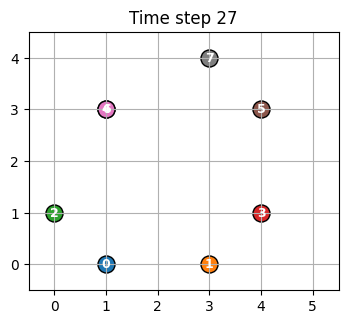

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ─── Replace this with your real pos_hist if needed ─────────────────────────
# pos_hist = np.load("pos_hist.npy")  # or however you get it
# ────────────────────────────────────────────────────────────────────────────

# Make sure pos_hist is a (T, Q, 2) array of ints
T, Q, _ = pos_hist.shape

# Where to save the individual PNGs
out_dir = "history_pngs"
os.makedirs(out_dir, exist_ok=True)

# Determine trap grid size from the data
n_rows = int(pos_hist[:,:,0].max() + 1)
n_cols = int(pos_hist[:,:,1].max() + 1)

for t in range(T):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_title(f"Time step {t}")
    ax.set_xlim(-0.5, n_cols - 0.5)
    ax.set_ylim(n_rows - 0.5, -0.5)
    ax.set_xticks(range(n_cols))
    ax.set_yticks(range(n_rows))
    ax.grid(True)

    # Plot each qubit as a colored dot with its index
    for q in range(Q):
        r, c = pos_hist[t, q]
        ax.scatter(c, r, s=150, edgecolor='black', linewidth=1)
        ax.text(c, r, str(q),
                ha='center', va='center',
                color='white', fontsize=9, fontweight='bold')

    ax.set_aspect('equal')
    ax.invert_yaxis()  # so row 0 is at the top, if you prefer

    filename = os.path.join(out_dir, f"step_{t:03d}.png")
    fig.savefig(filename, dpi=100, bbox_inches='tight')
    plt.close(fig)

print(f"Wrote {T} PNG files to `{out_dir}`")


In [18]:
from verifier import verifier
from fidelity import fidelity
import trap

pos_sequence = [
    [tuple(pos) for pos in pos_hist[t+1]]
    for t in range(len(scheduled_ops))
]

print(pos_sequence)
print(scheduled_ops)

graph = trap.create_trap_graph()

verifier(pos_sequence, scheduled_ops, graph)
fidelity(pos_sequence, scheduled_ops, graph)

[[(0, 1), (0, 3), (1, 0), (1, 4), (3, 0), (3, 4), (4, 1), (4, 3)], [(0, 1), (0, 3), (1, 0), (1, 4), (3, 0), (3, 4), (4, 1), (4, 3)], [(0, 1), (0, 3), (1, 0), (1, 4), (3, 0), (3, 4), (4, 1), (4, 3)], [(0, 1), (0, 3), (1, 0), (1, 4), (3, 0), (3, 4), (3, 1), (3, 3)], [(0, 1), (0, 3), (1, 0), (1, 4), (3, 0), (3, 4), (3, 1), (3, 2)], [(0, 1), (0, 3), (1, 0), (1, 4), (3, 0), (3, 4), (3, 1), (3, 1)], [(0, 1), (0, 3), (1, 0), (1, 4), (3, 0), (3, 4), (3, 1), (3, 1)], [(0, 1), (0, 3), (1, 0), (1, 4), (3, 0), (3, 4), (4, 1), (3, 2)], [(0, 1), (0, 3), (1, 0), (1, 4), (3, 0), (3, 4), (4, 1), (3, 3)], [(0, 1), (0, 3), (1, 0), (1, 4), (3, 0), (3, 4), (4, 1), (4, 3)], [(0, 1), (0, 3), (1, 0), (1, 4), (3, 0), (3, 4), (4, 1), (4, 3)], [(0, 1), (0, 3), (1, 0), (1, 4), (3, 0), (3, 4), (4, 1), (4, 3)], [(0, 1), (0, 3), (1, 0), (1, 4), (3, 0), (3, 4), (4, 1), (4, 3)], [(0, 1), (0, 3), (1, 0), (1, 4), (3, 0), (3, 4), (3, 1), (3, 3)], [(0, 1), (0, 3), (1, 0), (1, 4), (3, 0), (3, 4), (3, 1), (3, 2)], [(0, 1), 

0.9391489617251965

In [8]:
with open('circuit_output.txt', 'w', encoding='utf-8') as f:
    for ops in scheduled_ops:
        # repr(ops) gives you something like:
        #   [('RX', -2.35619, 7), ...]
        f.write(repr(ops) + '\n')

In [9]:
import pennylane as qml
from pennylane import numpy as np

n = 8
dev = qml.device("default.qubit", wires=n)

def custom_qft(wires):
    """Forward QFT on `wires` (no final swap) using RY and CPhase."""
    for k in range(len(wires)):
        # Hadamard via RY(π/2)
        qml.RY(np.pi/2, wires=wires[k])
        # Controlled-phase rotations
        for j in range(k+1, len(wires)):
            angle = np.pi / (2 ** (j - k))
            # PennyLane’s CPhase is allowed—internally this is a native
            # controlled-RZ, but you can decompose RZ into RX/RY if you like:
            qml.CPhase(angle, wires=[wires[k], wires[j]])

def bit_reverse_state(state):
    """Reverse the bit-order of an n-qubit statevector."""
    N = state.size
    m = int(np.log2(N))
    out = np.zeros_like(state)
    for i in range(N):
        rev = int(format(i, f'0{m}b')[::-1], 2)
        out[rev] = state[i]
    return out

@qml.qnode(dev)
def U_custom():
    custom_qft(range(n))
    return qml.state()

@qml.qnode(dev)
def U_builtin():
    qml.QFT(wires=range(n))
    return qml.state()

# Execute
state_c = U_custom()
state_c_br = bit_reverse_state(state_c)
state_b = U_builtin()

fidelity = abs(np.vdot(state_c_br, state_b))**2
print(f"State fidelity vs. built-in QFT: {fidelity:.8f}")


State fidelity vs. built-in QFT: 1.00000000


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import imageio  # type: ignore
import os, warnings

# ------------------------------------------------------------------
# pos_hist       (Tₚ, Q, 2)  : numpy array from your scheduler
# scheduled_ops  length Tₛ   : list[list[ops]] from your scheduler
# ------------------------------------------------------------------

Tp, Q, _ = pos_hist.shape
Ts = len(scheduled_ops)
T = min(Tp, Ts)

if Tp != Ts:
    warnings.warn(f"pos_hist has {Tp} ticks but scheduled_ops has {Ts}; "
                  f"animating first {T} ticks only.")

rows = int(pos_hist[:, :, 0].max()) + 1
cols = int(pos_hist[:, :, 1].max()) + 1

frames_dir = "frames"
os.makedirs(frames_dir, exist_ok=True)
frame_files = []

for t in range(T):
    # ---- red: single-qubit ops in *this* tick ---------------------------
    sq_highlight = {q for name, *rest in scheduled_ops[t]
                    if name in ("RX", "RY")
                    for q in rest[-1:]}

    # ---- green: MS gate qubits from *previous* tick ---------------------
    ms_highlight = set()
    if t > 0:
        for name, *rest in scheduled_ops[t-1]:
            if name == "MS":
                ms_highlight.update(rest[-1])   # (q1,q2)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5)
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    ax.grid(True)
    ax.set_aspect("equal")

    for q in range(Q):
        r, c = pos_hist[t, q]
        if q in ms_highlight:
            ax.scatter(c, r, s=350, color="limegreen",
                       edgecolor="black", zorder=3)
            ax.text(c, r, str(q), color="white", weight="bold",
                    ha="center", va="center", zorder=4)
        elif q in sq_highlight:
            ax.scatter(c, r, s=350, color="red",
                       edgecolor="black", zorder=3)
            ax.text(c, r, str(q), color="white", weight="bold",
                    ha="center", va="center", zorder=4)
        else:
            ax.scatter(c, r, s=200, facecolors="none",
                       edgecolors="black", zorder=2)
            ax.text(c, r, str(q), color="black",
                    ha="center", va="center")

    ax.set_title(f"Time step {t}")
    fname = os.path.join(frames_dir, f"frame_{t:03d}.png")
    fig.savefig(fname, dpi=100, bbox_inches="tight")
    plt.close(fig)
    frame_files.append(fname)

# Build GIF ------------------------------------------------------------------
gif_path = "movement.gif"
with imageio.get_writer(gif_path, mode="I", duration=2) as writer:
    for fname in frame_files:
        writer.append_data(imageio.imread(fname))

print(f"Saved animation to {gif_path}")


C:\Users\senli\AppData\Local\Temp\ipykernel_49528\1083563131.py:16: UserWarning: pos_hist has 174 ticks but scheduled_ops has 173; animating first 173 ticks only.
  warnings.warn(f"pos_hist has {Tp} ticks but scheduled_ops has {Ts}; "
C:\Users\senli\AppData\Local\Temp\ipykernel_49528\1083563131.py:75: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(fname))


Saved animation to movement.gif


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os, warnings

# --------------------------------------------------------------------
# pos_hist       (T, Q, 2) int ndarray  – already in memory
# scheduled_ops  list[list[ops]]       – same length T
# --------------------------------------------------------------------

T, Q, _ = pos_hist.shape
if len(scheduled_ops) != T:
    warnings.warn(
        f"scheduled_ops has {len(scheduled_ops)} entries "
        f"but pos_hist has {T}; using the shorter length."
    )
    T = min(T, len(scheduled_ops))

rows = int(pos_hist[:, :, 0].max()) + 1
cols = int(pos_hist[:, :, 1].max()) + 1

out_dir = "history_pngs"
os.makedirs(out_dir, exist_ok=True)

for t in range(T):
    # ── determine highlights for this frame ──────────────────────────
    sq_red = {q for name, *rest in scheduled_ops[t]
              if name in ("RX", "RY")
              for q in rest[-1:]}

    ms_green = set()
    if t > 0:
        for name, *rest in scheduled_ops[t - 1]:
            if name == "MS":
                ms_green.update(rest[-1])        # (q1,q2)

    # ── plot frame ──────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_title(f"Time step {t}")
    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5)
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    ax.grid(True)
    ax.set_aspect("equal")

    for q in range(Q):
        r, c = pos_hist[t, q]

        if q in ms_green:
            ax.scatter(c, r, s=250, color="limegreen",
                       edgecolor="black", linewidth=1, zorder=3)
            txt_color = "white"
        elif q in sq_red:
            ax.scatter(c, r, s=250, color="red",
                       edgecolor="black", linewidth=1, zorder=3)
            txt_color = "white"
        else:
            ax.scatter(c, r, s=150, facecolors="none",
                       edgecolors="black", linewidth=1)
            txt_color = "black"

        ax.text(c, r, str(q), ha="center", va="center",
                color=txt_color, fontweight="bold", fontsize=9)

    ax.invert_yaxis()  # row 0 at top (optional)

    fname = os.path.join(out_dir, f"step_{t:03d}.png")
    fig.savefig(fname, dpi=100, bbox_inches="tight")
    plt.close(fig)

print(f"Wrote {T} PNG files to '{out_dir}'")


C:\Users\senli\AppData\Local\Temp\ipykernel_32548\2543242958.py:12: UserWarning: scheduled_ops has 292 entries but pos_hist has 293; using the shorter length.
  warnings.warn(


Wrote 292 PNG files to 'history_pngs'


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import imageio  # type: ignore
import os, warnings

# ------------------------------------------------------------------
# pos_hist       : list-of-lists or numpy array of shape (Tₚ, Q, 2) or (Tₚ, Q, 3)
#                  entries are (row, col) or (row, col, "idle")
# scheduled_ops  : list of length Tₛ, each a list of ops
# ------------------------------------------------------------------

scheduled_ops.append([])

# determine dimensions from list or array
Tp = len(pos_hist)
Q  = len(pos_hist[0])
Ts = len(scheduled_ops)
T  = min(Tp, Ts)

if Tp != Ts:
    warnings.warn(f"pos_hist has {Tp} ticks but scheduled_ops has {Ts}; "
                  f"animating first {T} ticks only.")

# compute grid extents
all_rows = []
all_cols = []
for frame in pos_hist[:T]:
    for entry in frame:
        r, c = entry[0], entry[1]
        all_rows.append(r)
        all_cols.append(c)
rows = max(all_rows) + 1
cols = max(all_cols) + 1

frames_dir = "frames"
os.makedirs(frames_dir, exist_ok=True)
frame_files = []

for t in range(T):
    # single-qubit ops in this tick
    sq_highlight = {
        q for name, *rest in scheduled_ops[t]
        if name in ("RX", "RY")
        for q in rest[-1:]
    }
    # MS qubits from previous tick
    ms_highlight = set()
    if t > 0:
        for name, *rest in scheduled_ops[t-1]:
            if name == "MS":
                ms_highlight.update(rest[-1])
    # idle qubits at this tick
    idle_highlight = {
        q for q in range(Q)
        if len(pos_hist[t][q]) == 3 and pos_hist[t][q][2] == "idle"
    }

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5)
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    ax.grid(True)
    ax.set_aspect("equal")

    for q in range(Q):
        entry = pos_hist[t][q]
        # unpack whether length 2 or 3
        r, c = entry[0], entry[1]

        if q in ms_highlight:
            ax.scatter(c, r, s=350, color="limegreen",
                       edgecolor="black", zorder=3)
            ax.text(c, r, str(q), color="white", weight="bold",
                    ha="center", va="center", zorder=4)

        elif q in sq_highlight:
            ax.scatter(c, r, s=350, color="red",
                       edgecolor="black", zorder=3)
            ax.text(c, r, str(q), color="white", weight="bold",
                    ha="center", va="center", zorder=4)

        elif q in idle_highlight:
            ax.scatter(c, r, s=300, color="skyblue",
                       edgecolor="black", zorder=3)
            ax.text(c, r, str(q), color="black", weight="bold",
                    ha="center", va="center", zorder=4)

        else:
            ax.scatter(c, r, s=200, facecolors="none",
                       edgecolors="black", zorder=2)
            ax.text(c, r, str(q), color="black",
                    ha="center", va="center")

    ax.set_title(f"Time step {t}")
    fname = os.path.join(frames_dir, f"frame_{t:03d}.png")
    fig.savefig(fname, dpi=100, bbox_inches="tight")
    plt.close(fig)
    frame_files.append(fname)

# Build GIF ------------------------------------------------------------------
gif_path = "movement.gif"
with imageio.get_writer(gif_path, mode="I", duration=2) as writer:
    for fname in frame_files:
        writer.append_data(imageio.imread(fname))

print(f"Saved animation to {gif_path}")


C:\Users\senli\AppData\Local\Temp\ipykernel_32548\1687954457.py:105: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(fname))


Saved animation to movement.gif
